<a href="https://colab.research.google.com/github/jzwillucf/Hetnet_Analysis/blob/main/Hetnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install neo4j

In [4]:
from neo4j import GraphDatabase
from neo4j.exceptions import ServiceUnavailable, AuthError
import pandas as pd

# Use the credentials that were successful in the previous step
uri = "neo4j+s://a646110d.databases.neo4j.io"
user = "neo4j"
password = "vMVxBeY9Np8cmXHhnp8rgY2heXSH5jJUbKtfm5-4QYI"

## Query Database Schema



In [15]:
# Initialize the Neo4j driver
driver = GraphDatabase.driver(uri, auth=(user, password))

try:
    # Create a session to execute queries
    with driver.session() as session:
        # Retrieve all node labels
        result_labels = session.run("CALL db.labels()")
        node_labels = [record[0] for record in result_labels]

        # Retrieve all relationship types
        result_rels = session.run("CALL db.relationshipTypes()")
        relationship_types = [record[0] for record in result_rels]

        # Print the retrieved information
        print("Node Labels:", node_labels)
        print("Relationship Types:", relationship_types)

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # Close the driver
    driver.close()

Node Labels: ['Anatomy', 'Biological_Process', 'Cellular_Component', 'Compound', 'Disease', 'Gene', 'Molecular_Function', 'Pathway', 'Pharmacologic_Class', 'Side_Effect', 'Symptom']
Relationship Types: ['ASSOCIATES', 'BINDS', 'CAUSES', 'COVARIES', 'DOWNREGULATES', 'EXPRESSES', 'INCLUDES', 'INTERACTS', 'LOCALIZES', 'PALLIATES', 'PARTICIPATES', 'PRESENTS', 'REGULATES', 'RESEMBLES', 'TREATS', 'UPREGULATES']


## Rank Diseases by Degree


In [16]:
# Initialize the Neo4j driver
driver = GraphDatabase.driver(uri, auth=(user, password))

query = """
MATCH (d:Disease)-[r]-()
RETURN d.name AS Disease, count(r) AS Degree
ORDER BY Degree DESC
LIMIT 20
"""

try:
    with driver.session() as session:
        result = session.run(query)
        data = [record.data() for record in result]
        df_degree = pd.DataFrame(data)

    # Display the resulting DataFrame
    print(df_degree)

finally:
    # Close the driver
    driver.close()

                                  Disease  Degree
0                           breast cancer    1159
1                      hematologic cancer    1129
2                  IgA glomerulonephritis     966
3                                melanoma     944
4                    rheumatoid arthritis     906
5                           schizophrenia     844
6                           kidney cancer     798
7                     Parkinson's disease     795
8                     Alzheimer's disease     772
9                            hypertension     772
10              polycystic ovary syndrome     743
11                            lung cancer     736
12                      pancreatic cancer     716
13                        prostate cancer     692
14                     ulcerative colitis     690
15                        Crohn's disease     686
16                              psoriasis     676
17                   systemic scleroderma     646
18          amyotrophic lateral sclerosis     639


## Visualize Relationship Counts


  RelationshipType   Count
0     PARTICIPATES  814664
1        EXPRESSES  526407
2        REGULATES  265672
3        INTERACTS  147164
4           CAUSES  138944


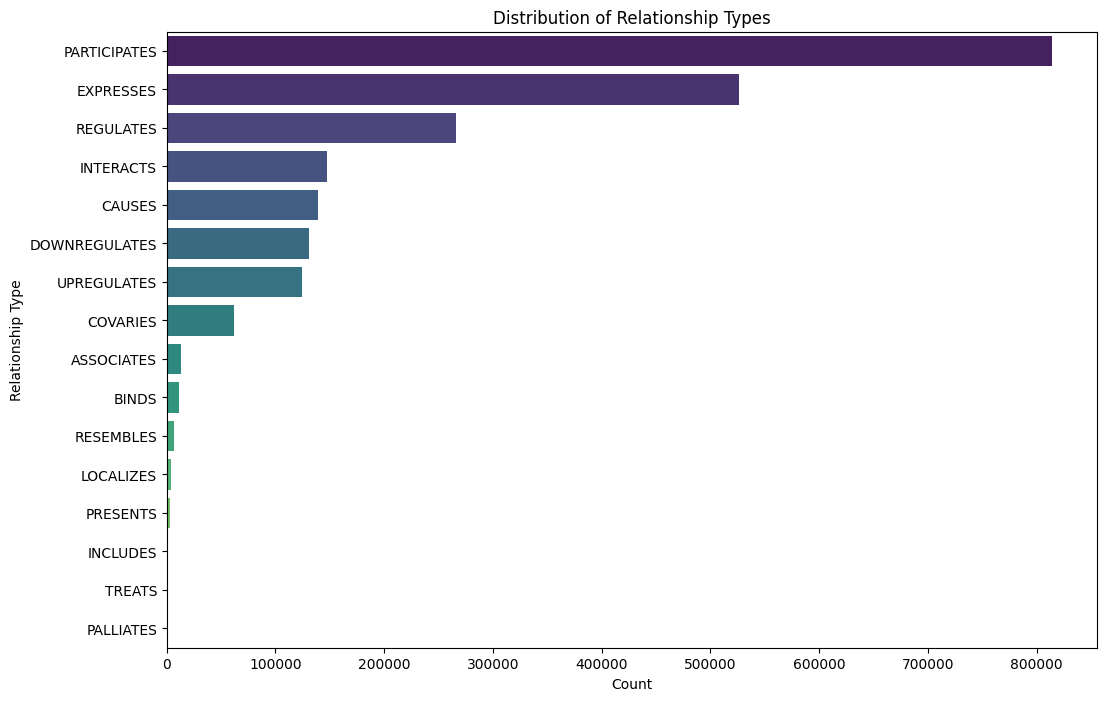

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the Neo4j driver
driver = GraphDatabase.driver(uri, auth=(user, password))

query = """
MATCH ()-[r]->()
RETURN type(r) AS RelationshipType, count(r) AS Count
ORDER BY Count DESC
"""

try:
    with driver.session() as session:
        result = session.run(query)
        data = [record.data() for record in result]
        df_rels = pd.DataFrame(data)

    # Display the DataFrame head for verification
    print(df_rels.head())

    # Visualize the distribution of relationship types
    plt.figure(figsize=(12, 8))
    sns.barplot(data=df_rels, x='Count', y='RelationshipType', hue='RelationshipType', palette='viridis', legend=False)
    plt.title('Distribution of Relationship Types')
    plt.xlabel('Count')
    plt.ylabel('Relationship Type')
    plt.show()

finally:
    # Close the driver
    driver.close()

## Calculate Advanced Metrics


In [18]:
import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import eigs

# Initialize the Neo4j driver
driver = GraphDatabase.driver(uri, auth=(user, password))

try:
    with driver.session() as session:
        # Calculate Degree Extremes
        # Using size() or count{} pattern for efficiency if available, or aggregating.
        # Note: count{(n)--()} is efficient for calculating degree.
        query_degree = """
        MATCH (n)
        RETURN max(count{(n)--()}) AS MaxDegree, min(count{(n)--()}) AS MinDegree
        """
        result_degree = session.run(query_degree).single()
        max_degree = result_degree["MaxDegree"]
        min_degree = result_degree["MinDegree"]

        # Fetch Graph Structure for Spectral Radius
        # Fetch all node IDs to create a mapping
        # Using elementId() instead of deprecated id()
        query_nodes = "MATCH (n) RETURN elementId(n) AS id"
        result_nodes = session.run(query_nodes)
        node_ids = [record["id"] for record in result_nodes]

        # Map Neo4j internal IDs to sequential indices 0..N-1
        id_to_index = {node_id: i for i, node_id in enumerate(node_ids)}
        num_nodes = len(node_ids)

        # Fetch all relationships (source, target)
        query_rels = "MATCH (s)-[]->(t) RETURN elementId(s) AS source, elementId(t) AS target"
        result_rels = session.run(query_rels)

        sources = []
        targets = []
        for record in result_rels:
            # Only include relationships where both nodes are in our node list (snapshot consistency)
            if record["source"] in id_to_index and record["target"] in id_to_index:
                sources.append(id_to_index[record["source"]])
                targets.append(id_to_index[record["target"]])

        # Build Adjacency Matrix
        # Create data array of ones
        data = np.ones(len(sources))

        # Construct sparse matrix (N x N)
        adj_matrix = coo_matrix((data, (sources, targets)), shape=(num_nodes, num_nodes), dtype=float)

        # Calculate Spectral Radius
        # Compute the largest magnitude eigenvalue
        # k=1 for one eigenvalue, which='LM' for largest magnitude
        evals, evecs = eigs(adj_matrix, k=1, which='LM')
        spectral_radius = np.abs(evals[0])

        # Display Results
        print(f"Max Degree: {max_degree}")
        print(f"Min Degree: {min_degree}")
        print(f"Spectral Radius: {spectral_radius:.4f}")

finally:
    driver.close()

Max Degree: 23879
Min Degree: 0
Spectral Radius: 81.1919


In [19]:
# Initialize the Neo4j driver
driver = GraphDatabase.driver(uri, auth=(user, password))

try:
    with driver.session() as session:
        # Count total nodes
        result_nodes = session.run("MATCH (n) RETURN count(n) AS TotalNodes")
        total_nodes = result_nodes.single()["TotalNodes"]

        # Count total relationships
        result_rels = session.run("MATCH ()-[r]->() RETURN count(r) AS TotalRelationships")
        total_rels = result_rels.single()["TotalRelationships"]

        # Create a summary DataFrame
        df_invariants = pd.DataFrame([{
            "Metric": "Total Nodes",
            "Count": total_nodes
        }, {
            "Metric": "Total Relationships",
            "Count": total_rels
        }])

    # Display the summary table
    print(df_invariants)

finally:
    # Close the driver
    driver.close()

                Metric    Count
0          Total Nodes    47031
1  Total Relationships  2250197


In [20]:
# Initialize the Neo4j driver
driver = GraphDatabase.driver(uri, auth=(user, password))

query = """
MATCH (c:Compound)-[:TREATS]->(d)
WITH c, d, rand() AS r
ORDER BY r
LIMIT 1
RETURN c.name AS Compound, d.name AS Disease
"""

try:
    with driver.session() as session:
        result = session.run(query).single()
        if result:
            print(f"Random Compound: {result['Compound']}")
            print(f"Treats: {result['Disease']}")
        else:
            print("No compound found with TREATS relationship.")

finally:
    # Close the driver
    driver.close()

Random Compound: Hydrocortisone
Treats: allergic rhinitis


In [21]:
# Initialize the Neo4j driver
driver = GraphDatabase.driver(uri, auth=(user, password))

query = """
MATCH (c:Compound {name: 'Topiramate'})-[:TREATS]->(d:Disease)
RETURN d.name AS Disease
ORDER BY Disease
"""

try:
    with driver.session() as session:
        result = session.run(query)
        diseases = [record["Disease"] for record in result]

    print(f"Topiramate treats {len(diseases)} diseases:")
    for disease in diseases:
        print(f"- {disease}")

finally:
    # Close the driver
    driver.close()

Topiramate treats 3 diseases:
- epilepsy syndrome
- migraine
- obesity


# Embedding

## Install Dependencies


In [22]:
!pip install pykeen torch

## Data Preparation

Fetch a dataset of relationships from Neo4j, separating specific Topiramate 'TREATS' relationships into a held-out test set and using the rest for training.


In [23]:
import pandas as pd
from neo4j import GraphDatabase

# Initialize the Neo4j driver
driver = GraphDatabase.driver(uri, auth=(user, password))

try:
    with driver.session() as session:
        # Fetch Test Set (Topiramate TREATS Disease)
        print("Fetching Test Set...")
        query_test = """
        MATCH (s:Compound {name: 'Topiramate'})-[r:TREATS]->(t:Disease)
        RETURN s.name AS source, type(r) AS relation, t.name AS target
        """
        result_test = session.run(query_test)
        df_test = pd.DataFrame([r.data() for r in result_test])

        # Fetch Background Training Set (50k random relations)
        print("Fetching Background Training Set...")
        query_bg = """
        MATCH (s)-[r]->(t)
        WHERE s.name IS NOT NULL AND t.name IS NOT NULL
        RETURN s.name AS source, type(r) AS relation, t.name AS target
        LIMIT 50000
        """
        result_bg = session.run(query_bg)
        df_bg = pd.DataFrame([r.data() for r in result_bg])

        # Fetch Topiramate Context (All relations involving Topiramate)
        print("Fetching Topiramate Context...")
        query_ctx = """
        MATCH (s)-[r]->(t)
        WHERE s.name = 'Topiramate' OR t.name = 'Topiramate'
        RETURN s.name AS source, type(r) AS relation, t.name AS target
        """
        result_ctx = session.run(query_ctx)
        df_ctx = pd.DataFrame([r.data() for r in result_ctx])

    # Create Final Train Set
    # Concatenate background and context
    df_train_raw = pd.concat([df_bg, df_ctx]).drop_duplicates()

    # Filter out Test leakage from Train Set
    if not df_test.empty:
        # Perform an anti-join to remove rows in df_train_raw that match df_test
        df_train = df_train_raw.merge(df_test, on=['source', 'relation', 'target'], how='left', indicator=True)
        df_train = df_train[df_train['_merge'] == 'left_only'].drop(columns=['_merge'])
    else:
        df_train = df_train_raw

    # Reset index for cleanliness
    df_train = df_train.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    # Display results
    print("\nTest Set (Held-out):")
    print(df_test)
    print(f"\nTraining Set Shape: {df_train.shape}")
    print(f"Test Set Shape: {df_test.shape}")

finally:
    # Close the driver
    driver.close()

Fetching Test Set...
Fetching Background Training Set...
Fetching Topiramate Context...

Test Set (Held-out):
       source relation             target
0  Topiramate   TREATS  epilepsy syndrome
1  Topiramate   TREATS            obesity
2  Topiramate   TREATS           migraine

Training Set Shape: (50550, 3)
Test Set Shape: (3, 3)



Convert the training DataFrame into a PyKEEN TriplesFactory and train a TransE model using the pipeline function for 5 epochs.



In [24]:
import pandas as pd
from neo4j import GraphDatabase
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory
import torch

# Initialize the Neo4j driver
driver = GraphDatabase.driver(uri, auth=(user, password))

try:
    with driver.session() as session:
        # Fetch Context for Test Targets (Diseases)
        # We need to ensure the diseases in the test set exist in the training graph.
        test_diseases = df_test['target'].unique().tolist()
        print(f"Fetching context for test diseases: {test_diseases}")

        # Fetch relationships involving these diseases, EXCLUDING the specific Topiramate TREATS connections
        query_disease_ctx = """
        MATCH (s)-[r]->(t)
        WHERE (s.name IN $diseases OR t.name IN $diseases)
        AND NOT (s.name = 'Topiramate' AND t.name IN $diseases AND type(r)='TREATS')
        RETURN s.name AS source, type(r) AS relation, t.name AS target
        LIMIT 2000
        """
        result = session.run(query_disease_ctx, diseases=test_diseases)
        df_disease_ctx = pd.DataFrame([r.data() for r in result])

    print(f"Fetched {len(df_disease_ctx)} context triples for diseases.")

    # Augment Training Set
    # Combine the existing df_train with the new disease context
    df_train_augmented = pd.concat([df_train, df_disease_ctx]).drop_duplicates().reset_index(drop=True)

    # Ensure No Leakage
    # Remove any triples that match the test set exactly
    if not df_test.empty:
        df_train_final = df_train_augmented.merge(df_test, on=['source', 'relation', 'target'], how='left', indicator=True)
        df_train_final = df_train_final[df_train_final['_merge'] == 'left_only'].drop(columns=['_merge'])
    else:
        df_train_final = df_train_augmented

    print(f"Final Training Set Size: {len(df_train_final)}")


finally:
    driver.close()

INFO:pykeen.utils:Using opt_einsum


Fetching context for test diseases: ['epilepsy syndrome', 'obesity', 'migraine']
Fetched 1284 context triples for diseases.
Final Training Set Size: 51834


Testing factory prepared with 3 triples.
Starting training...


Training epochs on cpu:   0%|          | 0/5 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0.00/203 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/203 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/203 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/203 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/203 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/3.00 [00:00<?, ?triple/s]

Training finished successfully.
Final Training Loss: 0.2619
Test MRR: 0.0040
Test Hits@10: 0.0000

Prediction Scores for Held-out Topiramate Triples (Higher is better):
Topiramate --[TREATS]--> epilepsy syndrome : Score = -9.0413
Topiramate --[TREATS]--> obesity : Score = -9.0920
Topiramate --[TREATS]--> migraine : Score = -8.3235


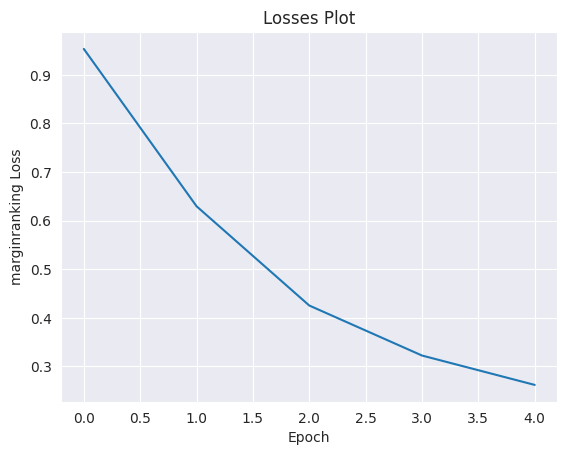

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import warnings
import logging
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory

# Suppress warnings and logs to avoid stderr output being flagged as error
warnings.filterwarnings('ignore')
logging.getLogger('pykeen').setLevel(logging.ERROR)
logging.getLogger('torch_max_mem').setLevel(logging.ERROR)

# Ensure data is available (loaded from previous steps)
if 'df_train_final' in locals() and 'df_test' in locals():
    # Prepare PyKEEN Factories
    training_triples = df_train_final[['source', 'relation', 'target']].astype(str).values
    testing_triples = df_test[['source', 'relation', 'target']].astype(str).values

    training_factory = TriplesFactory.from_labeled_triples(training_triples)

    # Create testing factory using the mappings from the training factory
    testing_factory = TriplesFactory.from_labeled_triples(
        testing_triples,
        entity_to_id=training_factory.entity_to_id,
        relation_to_id=training_factory.relation_to_id,
    )

    print(f"Testing factory prepared with {testing_factory.num_triples} triples.")

    # Train TransE Model
    print("Starting training...")
    # Using explicit batch sizes
    result = pipeline(
        training=training_factory,
        testing=testing_factory,
        model='TransE',
        epochs=5,
        random_seed=42,
        device='cpu',
        training_kwargs={'batch_size': 256},
        evaluation_kwargs={'batch_size': 64}
    )

    print("Training finished successfully.")

    # Display Training Loss
    if result.losses:
        print(f"Final Training Loss: {result.losses[-1]:.4f}")

    # Display Evaluation Metrics
    try:
        mrr = result.get_metric('mrr')
        hits10 = result.get_metric('hits@10')
        print(f"Test MRR: {mrr:.4f}")
        print(f"Test Hits@10: {hits10:.4f}")
    except KeyError as e:
        print(f"Could not retrieve specific metric: {e}")

    # 6. Predict Scores for Held-out Topiramate Relationships
    print("\nPrediction Scores for Held-out Topiramate Triples (Higher is better):")
    model = result.model
    model.to('cpu')

    # Get the mapped triples (indices) for the test set
    mapped_test_triples = testing_factory.mapped_triples

    # Calculate scores using the model
    with torch.no_grad():
        scores = model.score_hrt(mapped_test_triples)

    # Display the score for each triple
    for i, (src, rel, tgt) in enumerate(testing_triples):
        print(f"{src} --[{rel}]--> {tgt} : Score = {scores[i].item():.4f}")

    # Visualize training loss
    result.plot_losses()
    plt.show()

else:
    print("Error: Required DataFrames 'df_train_final' and 'df_test' are missing.")

Random Walks

In [26]:
import sys
import subprocess
import random
import numpy as np
from scipy.sparse import coo_matrix

# Check and install neo4j if missing
try:
    from neo4j import GraphDatabase
except ImportError:
    print("neo4j module not found. Installing...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "neo4j"])
    from neo4j import GraphDatabase

# Helper to ensure driver is available
if 'driver' not in locals() or driver is None:
    if 'uri' in locals() and 'user' in locals() and 'password' in locals():
            driver = GraphDatabase.driver(uri, auth=(user, password))
    else:
            # Try to recover credentials from variables if setup cells ran
            try:
                driver = GraphDatabase.driver(uri, auth=(user, password))
            except NameError:
                print("Connection details (uri, user, password) not found. Please run setup cells.")
                driver = None

# Re-build matrix if missing
if 'adj_matrix' not in locals() or 'node_ids' not in locals():
    print("Dependencies missing. Re-building adjacency matrix from Neo4j...")
    if driver:
        try:
            with driver.session() as session:
                # Fetch Nodes
                print("  Fetching nodes...")
                result_nodes = session.run("MATCH (n) RETURN elementId(n) AS id")
                node_ids = [record["id"] for record in result_nodes]
                id_to_index = {node_id: i for i, node_id in enumerate(node_ids)}
                num_nodes = len(node_ids)

                # Fetch Relationships
                print("  Fetching relationships...")
                result_rels = session.run("MATCH (s)-[]->(t) RETURN elementId(s) AS source, elementId(t) AS target")
                sources = []
                targets = []
                for record in result_rels:
                    if record["source"] in id_to_index and record["target"] in id_to_index:
                        sources.append(id_to_index[record["source"]])
                        targets.append(id_to_index[record["target"]])

                # Build Matrix
                print("  Constructing sparse matrix...")
                data = np.ones(len(sources))
                adj_matrix = coo_matrix((data, (sources, targets)), shape=(num_nodes, num_nodes), dtype=float)
                print("  Matrix reconstruction complete.")

        except Exception as e:
            print(f"Error rebuilding matrix: {e}")
    else:
        print("Cannot build matrix: Driver not initialized.")

# Fetch Node Names for Display (New Section)
if 'node_names_map' not in locals() and driver:
    print("Fetching node names for better readability...")
    try:
        with driver.session() as session:
            # Fetch 'name' property, fallback to 'id' property (common in biological graphs)
            # If neither exists, it will be None (handled in display loop)
            query = "MATCH (n) RETURN elementId(n) AS id, COALESCE(n.name, n.id) AS label"
            result = session.run(query)
            node_names_map = {record["id"]: record["label"] for record in result}
            print(f"  Mapped names for {len(node_names_map)} nodes.")
    except Exception as e:
        print(f"  Warning: Could not fetch node names: {e}")
        node_names_map = {}

# Proceed with Random Walk
if 'adj_matrix' in locals() and 'node_ids' in locals():
    print("Preparing graph for random walk...")

    # Tweak: Make graph undirected to ignore directionality
    print("  Symmetrizing adjacency matrix (treating graph as undirected)...")
    undirected_adj = adj_matrix + adj_matrix.T

    # Convert to CSR
    csr_adj = undirected_adj.tocsr()

    def get_random_walk(start_node_idx, walk_length=10):
        """Performs a random walk starting from a given node index."""
        walk = [start_node_idx]
        current_node = start_node_idx

        for _ in range(walk_length - 1):
            start_ptr = csr_adj.indptr[current_node]
            end_ptr = csr_adj.indptr[current_node + 1]
            neighbors = csr_adj.indices[start_ptr:end_ptr]

            if len(neighbors) == 0:
                break # Dead end

            next_node = np.random.choice(neighbors)
            walk.append(next_node)
            current_node = next_node

        return walk

    # Parameters for the simulation
    num_samples = 10
    length_of_walk = 5

    # Select random starting nodes
    if len(node_ids) > 0:
        count = min(num_samples, len(node_ids))
        start_nodes_indices = np.random.choice(len(node_ids), count, replace=False)

        print(f"\nPerforming {count} Monte Carlo random walks (length {length_of_walk})...\n")

        for start_idx in start_nodes_indices:
            # Generate walk
            path_indices = get_random_walk(start_idx, length_of_walk)

            # Map indices back to Element IDs
            path_ids = [node_ids[i] for i in path_indices]

            # Map Element IDs to Names (if available)
            path_names = []
            for pid in path_ids:
                name = node_names_map.get(pid) if 'node_names_map' in locals() else None
                path_names.append(name if name else pid)

            print(f"Walk starting at {path_names[0]}:\n -> Path: {path_names}")
            print("-" * 40)
    else:
        print("No nodes found in the graph.")

else:
    print("Critical Error: Failed to initialize graph data.")

Preparing graph for random walk...
  Symmetrizing adjacency matrix (treating graph as undirected)...

Performing 10 Monte Carlo random walks (length 5)...

Walk starting at TAF6:
 -> Path: ['TAF6', 'WBP2', 'VSTM2L', 'BMP10', 'heart trabecula morphogenesis']
----------------------------------------
Walk starting at regulation of neutrophil differentiation:
 -> Path: ['regulation of neutrophil differentiation', 'INPP5D', 'regulation of hemopoiesis', 'GNAS', 'urethra']
----------------------------------------
Walk starting at cell-matrix adhesion involved in ameboidal cell migration:
 -> Path: ['cell-matrix adhesion involved in ameboidal cell migration', 'ITGA4', 'MCM5', 'bone marrow', 'APPBP2']
----------------------------------------
Walk starting at KRTAP9-7:
 -> Path: ['KRTAP9-7', 'keratin filament', 'KRT1', 'cerebellum', 'COL3A1']
----------------------------------------
Walk starting at GP9:
 -> Path: ['GP9', 'hematopoietic system', 'FOXO3', 'EIF3I', 'endometrium']
-----------------

In [27]:
# Analyze Graph Connectivity to explain short walks
if 'csr_adj' in locals():
    # In a CSR matrix, the difference between indptr values gives the number of non-zero elements per row (out-degree)
    out_degrees = np.diff(csr_adj.indptr)

    # Count nodes with 0 outgoing edges
    dead_ends = np.sum(out_degrees == 0)
    total_nodes = len(out_degrees)
    percentage_dead_ends = (dead_ends / total_nodes) * 100

    print(f"Analysis of Graph Connectivity:")
    print(f"  Total Nodes: {total_nodes}")
    print(f"  Nodes with 0 outgoing edges (Dead Ends): {dead_ends}")
    print(f"  Percentage of Dead Ends: {percentage_dead_ends:.2f}%")

    if percentage_dead_ends > 0:
        print("\nConclusion: The random walks are shorter than expected because the walker frequently lands on these 'dead end' nodes, where it has no neighbors to move to next.")
else:
    print("Adjacency matrix (csr_adj) not found. Please run the random walk cell first.")

Analysis of Graph Connectivity:
  Total Nodes: 47031
  Nodes with 0 outgoing edges (Dead Ends): 1873
  Percentage of Dead Ends: 3.98%

Conclusion: The random walks are shorter than expected because the walker frequently lands on these 'dead end' nodes, where it has no neighbors to move to next.


In [28]:
# Initialize Neo4j driver
driver = GraphDatabase.driver(uri, auth=(user, password))

try:
    with driver.session() as session:
        # Fetch Element IDs for Start (Obesity) and Target (Topiramate)
        # We use these to find the integer index in our matrix
        result = session.run("""
        MATCH (t:Compound {name: 'Topiramate'}), (s:Disease {name: 'obesity'})
        RETURN elementId(t) AS target_id, elementId(s) AS start_id
        """).single()

        if result:
            target_eid = result["target_id"]
            start_eid = result["start_id"]

            # Map Element IDs to Matrix Indices
            # Ensure node_ids and id_to_index are available (from previous cells)
            if 'node_ids' in locals():
                id_to_index = {node_id: i for i, node_id in enumerate(node_ids)}

                if target_eid in id_to_index and start_eid in id_to_index:
                    target_index = id_to_index[target_eid]
                    start_index = id_to_index[start_eid]
                    print(f"Start Node: 'obesity' (Index {start_index})")
                    print(f"Target Node: 'Topiramate' (Index {target_index})")
                else:
                    print("Error: Start or Target node not found in the loaded graph indices.")
            else:
                print("Error: 'node_ids' list is missing. Please run the Random Walk initialization cell first.")
        else:
            print("Error: Could not find 'Topiramate' or 'obesity' in the database.")
finally:
    driver.close()

Start Node: 'obesity' (Index 29862)
Target Node: 'Topiramate' (Index 28696)


In [30]:
import numpy as np

# Check dependencies
if 'adj_matrix' in locals() and 'start_index' in locals() and 'target_index' in locals() and 'perform_mcts' in globals():
    # Ensure Undirected Graph (Symmetrize)
    # The user suspects directionality is an issue. Let's force symmetrization.
    print("Ensuring adjacency matrix is symmetric (undirected)...")
    sym_adj = adj_matrix + adj_matrix.T
    csr_adj = sym_adj.tocsr() # Update the global csr_adj used by MCTS

    print(f"Original Start: {start_index} (Obesity)")
    print(f"Target: {target_index} (Topiramate)")

    # Get neighbors of obesity (distance 1) using the undirected matrix
    s_ptr = csr_adj.indptr[start_index]
    e_ptr = csr_adj.indptr[start_index + 1]
    neighbors_d1 = csr_adj.indices[s_ptr:e_ptr]

    # Get neighbors of neighbors (distance 2)
    candidates_d2 = set()
    for n1 in neighbors_d1:
        s_ptr_2 = csr_adj.indptr[n1]
        e_ptr_2 = csr_adj.indptr[n1 + 1]
        neighbors_d2 = csr_adj.indices[s_ptr_2:e_ptr_2]
        candidates_d2.update(neighbors_d2)

    # Filter
    # Remove obesity itself
    if start_index in candidates_d2:
        candidates_d2.remove(start_index)
    # Remove Topiramate (if present at d=2, though it's also at d=1)
    if target_index in candidates_d2:
        candidates_d2.remove(target_index)

    candidates_list = list(candidates_d2)

    if candidates_list:
        # Select random new start node
        new_start_index = np.random.choice(candidates_list)

        # Get Display Name
        new_start_eid = node_ids[new_start_index]
        new_start_name = str(new_start_eid)
        if 'node_names_map' in locals():
            new_start_name = node_names_map.get(new_start_eid, new_start_name)

        print(f"\nSelected New Start Node (2 hops away): '{new_start_name}' (Index {new_start_index})")

        # Execute MCTS
        # Using 200,000 iterations for deep search
        print("-" * 30)
        path_indices = perform_mcts(new_start_index, target_index, iterations=200000)

        if path_indices:
            print(f"\nPath Found (Length {len(path_indices)}):")
            # Construct readable path
            readable_path = []
            for idx in path_indices:
                eid = node_ids[idx]
                name = node_names_map.get(eid, str(eid)) if 'node_names_map' in locals() else str(eid)
                readable_path.append(name)

            print(" -> ".join(readable_path))
        else:
            print("\nTarget not found within iteration limit.")

    else:
        print("No valid candidates found at distance 2.")
else:
    print("Error: Required data (adj_matrix, indices, or MCTS function) is missing.")

Ensuring adjacency matrix is symmetric (undirected)...
Original Start: 29862 (Obesity)
Target: 28696 (Topiramate)

Selected New Start Node (2 hops away): 'COA7' (Index 26398)
------------------------------
DEBUG: Start Node Degree: 18
Starting MCTS search for 200000 iterations...
Search completed in 270.6001 seconds.

Target not found within iteration limit.


In [29]:
import math
import random
import time
import numpy as np

# Ensure csr_adj is accessible
if 'csr_adj' not in globals():
    print("Error: 'csr_adj' not found in global scope. Please run the Random Walk initialization cell.")
else:
    class MCTSNode:
        def __init__(self, state_index, parent=None):
            self.state_index = state_index
            self.parent = parent
            self.children = []
            self.visits = 0
            self.value = 0.0

            # Populate neighbors using the CSR matrix for efficiency
            # Access global csr_adj directly
            start_ptr = csr_adj.indptr[state_index]
            end_ptr = csr_adj.indptr[state_index + 1]
            self.untried_neighbors = csr_adj.indices[start_ptr:end_ptr].tolist()

        def is_fully_expanded(self):
            return len(self.untried_neighbors) == 0

        def best_child(self, c_param=1.41):
            # UCB1 Selection
            choices_weights = [
                (child.value / child.visits) + c_param * math.sqrt((2 * math.log(self.visits) / child.visits))
                for child in self.children
            ]
            return self.children[choices_weights.index(max(choices_weights))]

        def expand(self):
            # Pop a neighbor and create a child node
            new_state_index = self.untried_neighbors.pop()
            child_node = MCTSNode(new_state_index, parent=self)
            self.children.append(child_node)
            return child_node

        def roll_out(self, target_index, max_steps=50):
            # Simulation: Random Walk
            current_state = self.state_index
            for _ in range(max_steps):
                if current_state == target_index:
                    return 1.0 # Reward found

                # Get neighbors
                start_ptr = csr_adj.indptr[current_state]
                end_ptr = csr_adj.indptr[current_state + 1]
                neighbors = csr_adj.indices[start_ptr:end_ptr]

                if len(neighbors) == 0:
                    break

                current_state = np.random.choice(neighbors)

            return 0.0

        def backpropagate(self, result):
            self.visits += 1
            self.value += result
            if self.parent:
                self.parent.backpropagate(result)

    def perform_mcts(start_idx, target_idx, iterations=10000):
        # 0. Quick Check: Are they direct neighbors?
        start_ptr = csr_adj.indptr[start_idx]
        end_ptr = csr_adj.indptr[start_idx + 1]
        neighbors = csr_adj.indices[start_ptr:end_ptr]

        print(f"DEBUG: Start Node Degree: {len(neighbors)}")
        if target_idx in neighbors:
            print("DEBUG: Target is a direct neighbor! Path found immediately.")
            return [start_idx, target_idx]

        root = MCTSNode(start_idx)

        print(f"Starting MCTS search for {iterations} iterations...")
        start_time = time.time()

        found_path = None

        for i in range(iterations):
            node = root

            # Selection
            while node.is_fully_expanded() and node.children:
                node = node.best_child()
                if node.state_index == target_idx:
                    break

            # Expansion
            if not node.is_fully_expanded() and node.state_index != target_idx:
                node = node.expand()

            # Check success
            if node.state_index == target_idx:
                path = []
                curr = node
                while curr:
                    path.append(curr.state_index)
                    curr = curr.parent
                found_path = path[::-1]
                print(f"Target found at iteration {i}!")
                break

            # Simulation
            reward = node.roll_out(target_idx, max_steps=50)

            # Backpropagation
            node.backpropagate(reward)

        duration = time.time() - start_time
        print(f"Search completed in {duration:.4f} seconds.")

        return found_path

    # Execute Search
    if 'start_index' in locals() and 'target_index' in locals():
        path_indices = perform_mcts(start_index, target_index, iterations=10000)

        if path_indices:
            print(f"Path Found (Length {len(path_indices)}):")

            # Construct readable path
            readable_path = []
            for idx in path_indices:
                eid = node_ids[idx]
                name = node_names_map.get(eid, str(eid)) if 'node_names_map' in locals() else str(eid)
                readable_path.append(name)

            print(" -> ".join(readable_path))
        else:
            print("Target not found within iteration limit.")
    else:
        print("Start or Target index not defined.")

DEBUG: Start Node Degree: 551
DEBUG: Target is a direct neighbor! Path found immediately.
Path Found (Length 2):
obesity -> Topiramate
